In [1]:
push!(LOAD_PATH, "../src")

using MyProject.StochasticLanczos
using MyProject.Estimators
using MyProject.Utils
using LinearAlgebra
using Plots

## Block Dependence of Estimate Convergence
First, we explore the convergenece of the blocked algorithm to the Hutchinson estimator (for a fixed sample $\Omega$) with increasing Lanczos iterates as a funciton of the block size $b$.

In [2]:
include("test_cases/bcsstk09_case.jl");

In [3]:
s = 60
b = 5
k_converged = 40
Ω_provided = rand([-1,1], n, s)
converged_estimate = hutchinson_estimator(f, matvecA, n, s, b, k_converged; Ω_provided=Ω_provided, 
    reorthogonalization_fraction=1.0)

1.8338850825350792e10

In [4]:
ks = collect(1:1:15)
bs = divisors(s)[1:end-1]
partial_hutchinson_estimator = (b, k) -> 
                hutchinson_estimator(f, matvecA, n, s, b, k; Ω_provided=Ω_provided, reorthogonalization_fraction=1.0)
block_estimates = compute_block_estimates(ks, bs, partial_hutchinson_estimator);

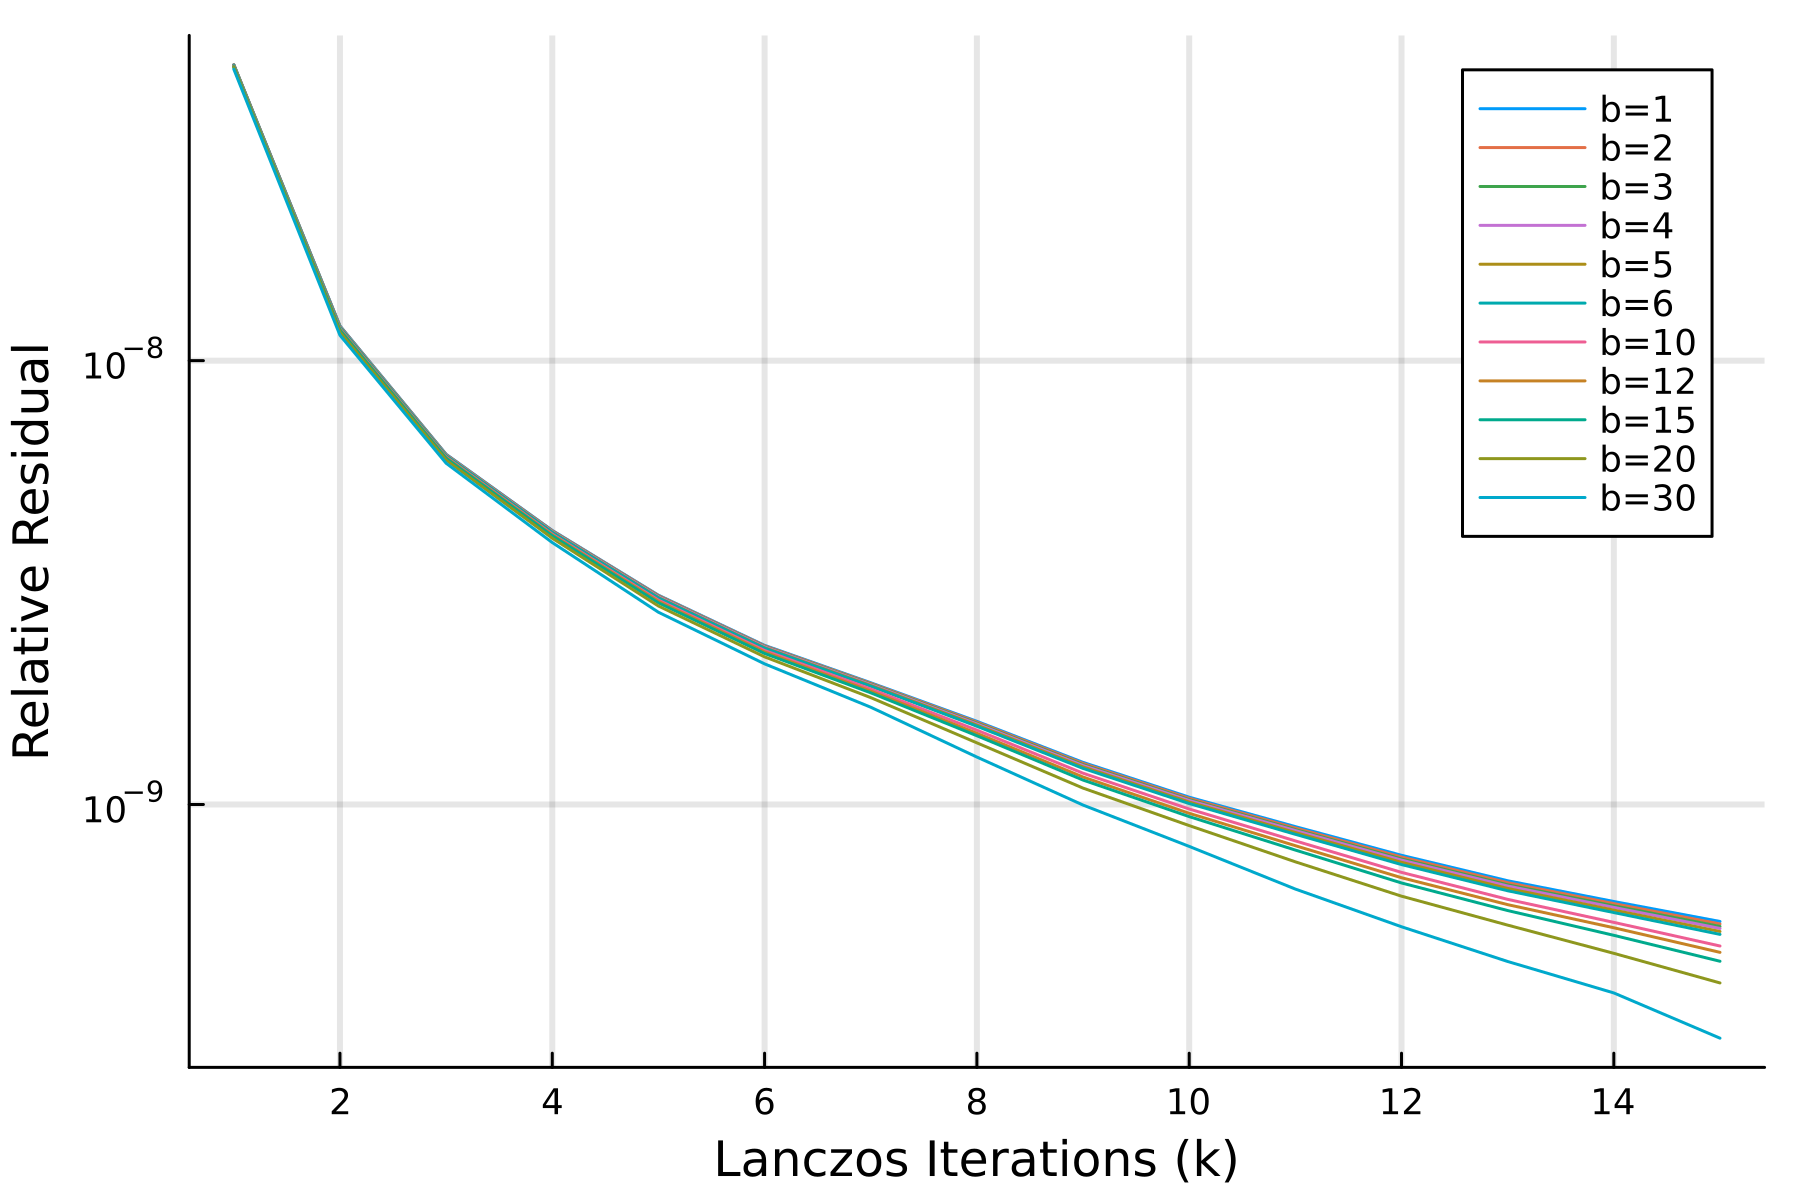

In [5]:
p = plot_block_estimates(block_estimates, ks, bs, converged_estimate; k_max=ks[end], logscale=true)
plot!(dpi=300)

In [6]:
savefig("bcsstk09_hutch_residual_block_dependence.png")

"/home/mlouis9/shared/Educational Stuffs/Classes/Fall 2024/Iterative Methods/MyProject/test/bcsstk09_hutch_residual_block_dependence.png"

## Block-Dependence of Hutch++ Estimator Convergence

In [7]:
s = 60
b = 5
k_converged = 40
Ω_provided = rand([-1,1], n, s)
converged_estimate = hutch_pp_estimator(f, matvecA, n, s, b, k_converged; Ω_provided=Ω_provided, 
    reorthogonalization_fraction=1.0)

6.964280773436385e9

In [8]:
ks = collect(1:1:15)
bs = divisors(s÷2)[1:end]
partial_hutch_pp_estimator = (b, k) -> 
                    hutch_pp_estimator(f, matvecA, n, s, b, k; Ω_provided=Ω_provided, reorthogonalization_fraction=1.0)
block_estimates = compute_block_estimates(ks, bs, partial_hutch_pp_estimator);

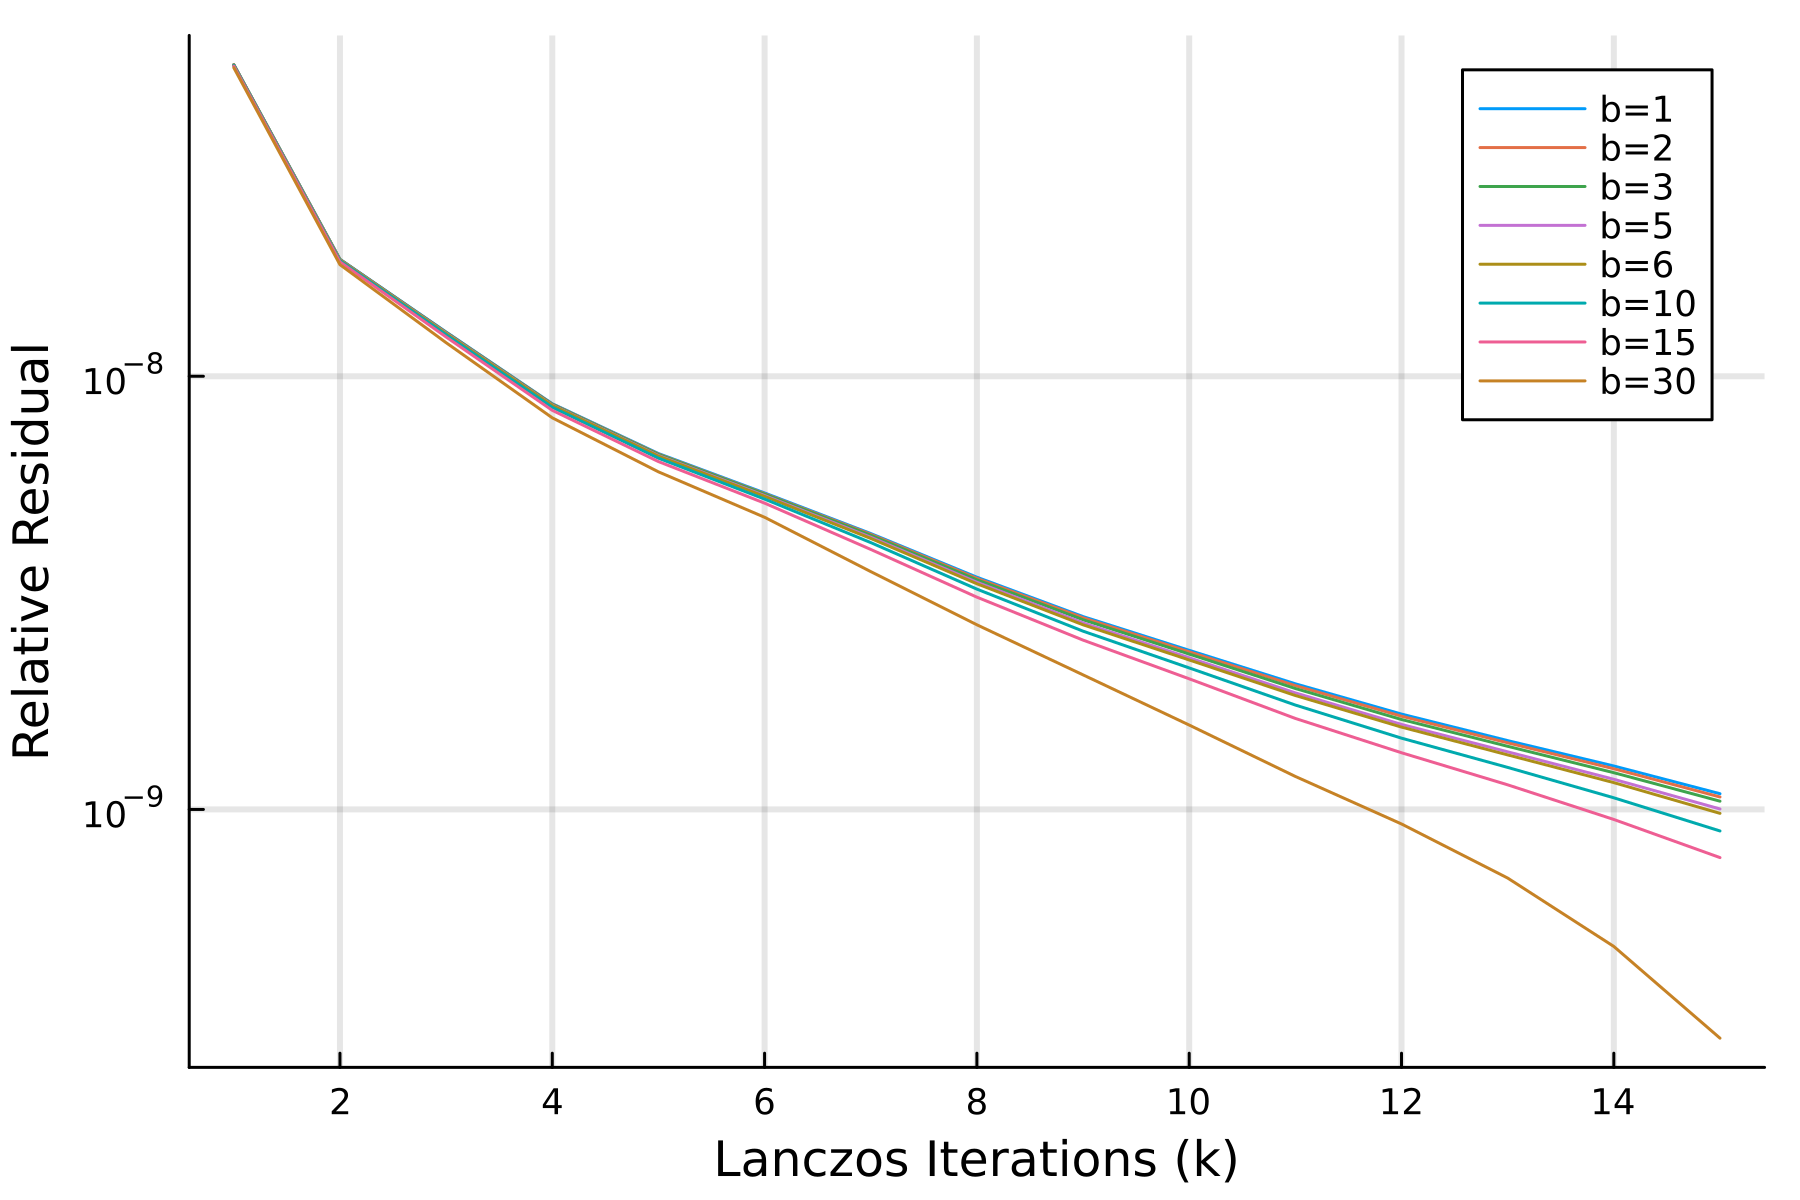

In [9]:
p = plot_block_estimates(block_estimates, ks, bs, converged_estimate; logscale=true)
plot!(dpi=300)

In [10]:
savefig("bcsstk09_hutch_pp_residual_block_dependence")

"/home/mlouis9/shared/Educational Stuffs/Classes/Fall 2024/Iterative Methods/MyProject/test/bcsstk09_hutch_pp_residual_block_dependence.png"

## Block-Dependence of Estimator Variance
First, note that the variance of the Hutchinson estimator (assuming it's computed exactly) is known apriori, and is given by
$$
\frac{2}{s}\sum_{i\neq j}\lvert \tilde{a}_{ij} \rvert^2
$$
however, it is not clear apirori how an ill-converged Lanczos iteration (which provides an approximation of the estimate) will affect the variance of the estimator. The hypothesis is that an ill converged Lanczos iteration will increase the estimator variance. To test that hypothesis, we can estimate the estimator variance as a function of both block size and Lanczos iterations. The hope is that this plot will show a trend similar to the above plot.

Recycle the block-estimates code and use a different partial function that instead returns the computed estimator variance

In [18]:
ks = collect(1:1:30)
bs = divisors(s)[1:end-3]
N = 1000 # The number of samples for computing variance estimates
partial_hutchinson_estimator = (b, k) -> 
                hutchinson_estimator(f, matvecA, n, s, b, k; reorthogonalization_fraction=1.0)
partial_variance_estimator = (b, k) ->
                estimator_statistics(partial_hutchinson_estimator, b, k; )[2] # Note [2] returns the variance, not the mean
block_variance_estimates = compute_block_estimates(ks, bs, partial_variance_estimator);

Now estimate the standard deviation of the sample variance ($S^2$) by the following (which holds well for a population which is approximately normal, which should be the case here) 
$$
\hat{\sigma}_{S^2} = S^2\sqrt{\frac{2}{N-1}}
$$
where $N$ is the number of samples

In [21]:
block_stddev_of_variance_estimates = block_variance_estimates .* sqrt(2/(N-1))

9×30 Matrix{Float64}:
 2.65763e14  3.07059e14  2.22256e14  …  1.37033e14  3.40236e14  1.91502e14
 2.39268e14  2.73705e14  2.84507e14     2.40894e14  1.74117e14  2.15068e14
 2.68393e14  2.11872e14  2.26361e14     2.36544e14  2.39213e14  2.75128e14
 1.8895e14   1.87287e14  2.50798e14     2.01539e14  2.26742e14  2.07498e14
 2.25824e14  2.12386e14  2.73032e14     2.41403e14  1.91574e14  2.06369e14
 1.95788e14  2.25784e14  2.54024e14  …  1.24917e14  1.85053e14  3.03122e14
 2.65658e14  3.06984e14  1.97191e14     2.19003e14  1.76677e14  2.27915e14
 1.69407e14  3.07102e14  1.59082e14     3.01049e14  1.40359e14  1.78782e14
 3.03901e14  2.15547e14  2.15263e14     1.8747e14   1.99892e14  2.00112e14

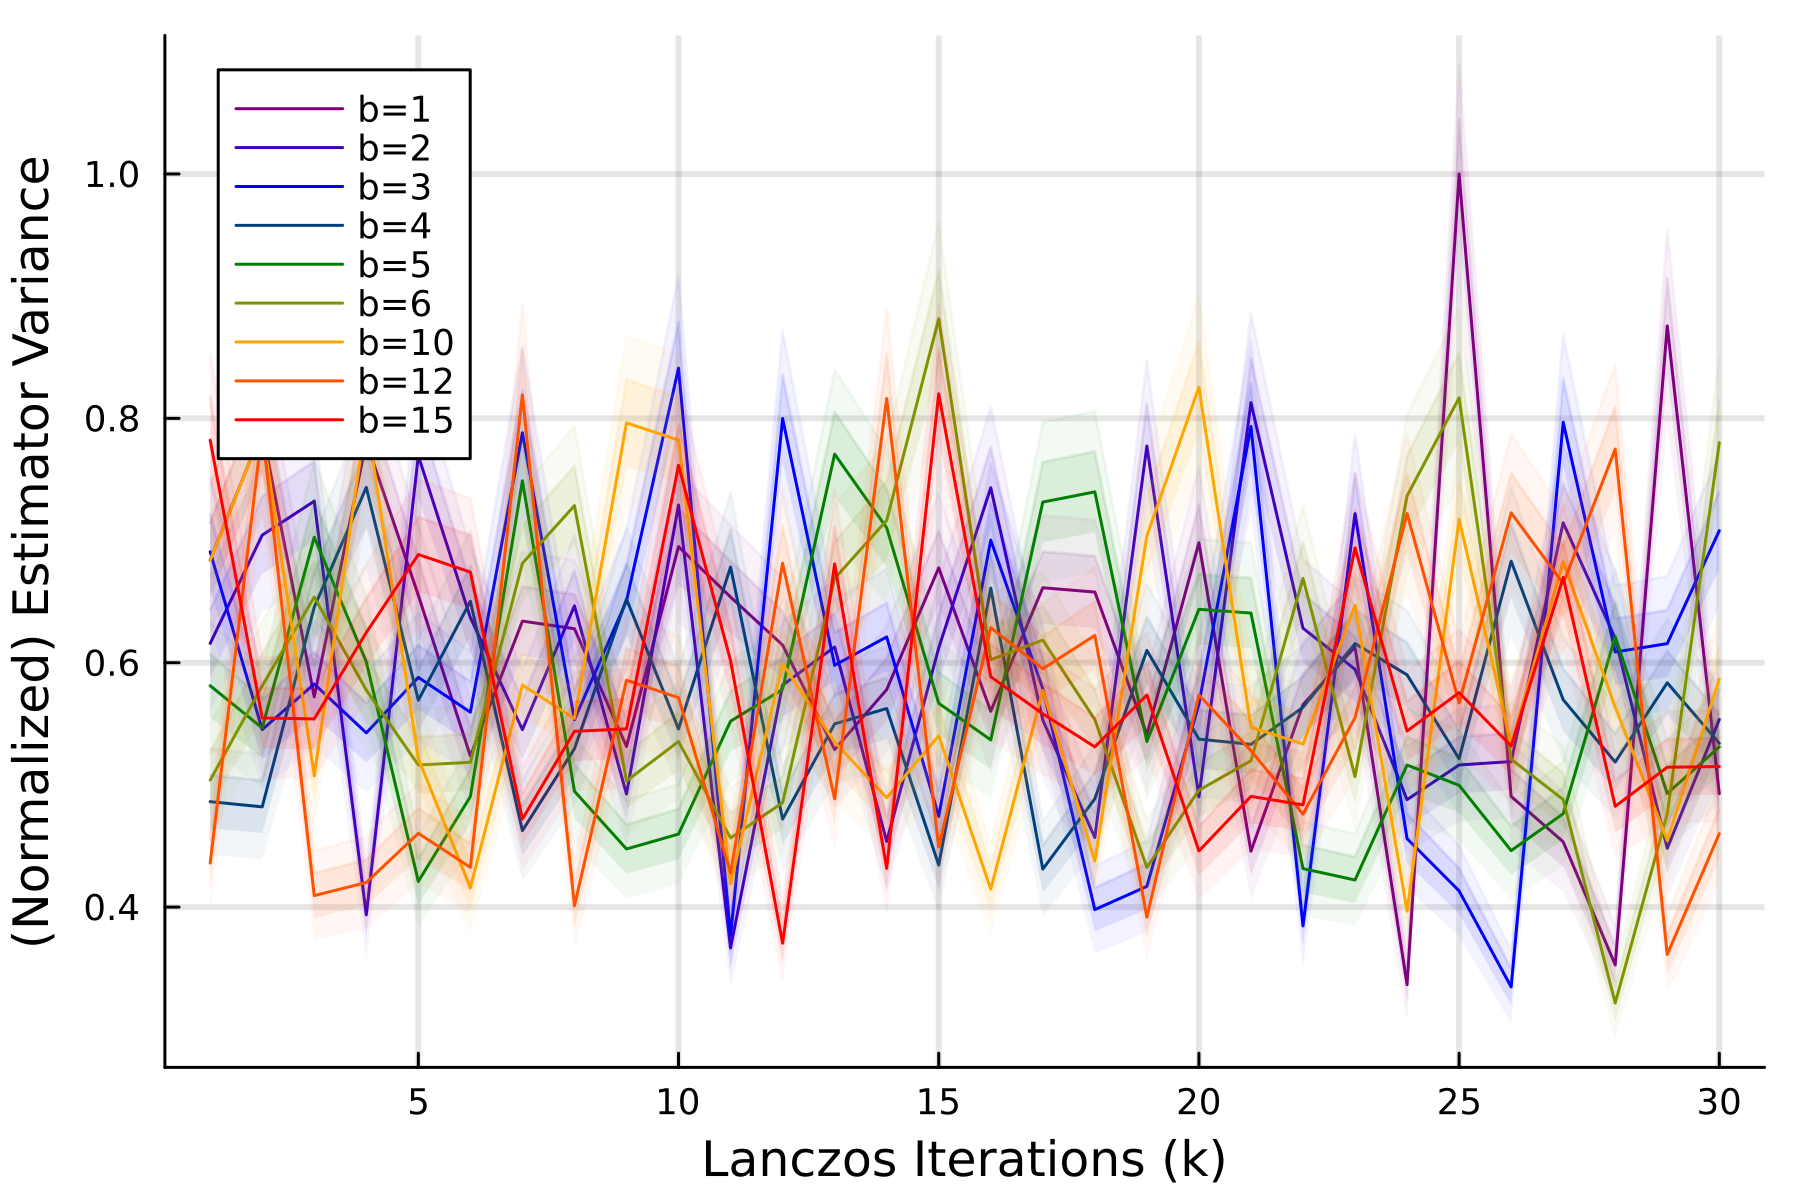

In [22]:
normalization = findmax(block_variance_estimates)[1]
p = plot_block_variance_estimates(block_variance_estimates./normalization, block_stddev_of_variance_estimates./normalization, ks, bs)
plot!(ylabel="(Normalized) Estimator Variance")
plot!(dpi=300)
display(p)

In [23]:
savefig("hutch_estimator_variance_vs_lanczos_iters.png")

"/home/mlouis9/shared/Educational Stuffs/Classes/Fall 2024/Iterative Methods/project/test/hutch_estimator_variance_vs_lanczos_iters.png"

## Hutch ++ Variance w.r.t. the number of Lanczos Iterations
Now we do the same thing but for the Hutch++ estimator. We would expect that the variance decreases with the number of samples s, and it should be roughly independent of the number of Lanczos iterates, as the above experiment seems to suggest (since the stochastic component of Hutch++ is just a Hutch estimation)

In [ ]:
ks = collect(1:1:15)
bs = divisors(s÷2)
N = 1000 # The number of samples for computing variance estimates
partial_hutch_pp_estimator = (b, k) -> 
                hutch_pp_estimator(f, matvecA, n, s, b, k; reorthogonalization_fraction=1.0)
partial_variance_estimator = (b, k) ->
                estimator_statistics(partial_hutch_pp_estimator, b, k; )[2] # Note [2] returns the variance, not the mean
block_variance_estimates = compute_block_estimates(ks, bs, partial_variance_estimator);
block_stddev_of_variance_estimates = block_variance_estimates .* sqrt(2/(N-1))

8×15 Matrix{Float64}:
 4.45664e14  4.72242e14  8.35929e14  …  4.01247e14  4.62501e14  5.7401e14
 3.52484e14  3.86007e14  5.21075e14     4.70737e14  5.62562e14  5.08987e14
 5.74765e14  3.54754e14  6.50069e14     4.48696e14  4.89044e14  5.27183e14
 5.13875e14  4.89037e14  4.35212e14     4.18804e14  4.62994e14  4.66733e14
 3.56062e14  4.88349e14  3.24515e14     5.8183e14   4.32172e14  6.33425e14
 7.75717e14  5.49981e14  6.64762e14  …  3.91028e14  4.03533e14  7.52778e14
 5.29137e14  8.04954e14  6.48157e14     4.27577e14  5.52457e14  3.54125e14
 6.03504e14  4.00193e14  5.78198e14     4.66877e14  3.26561e14  6.58461e14

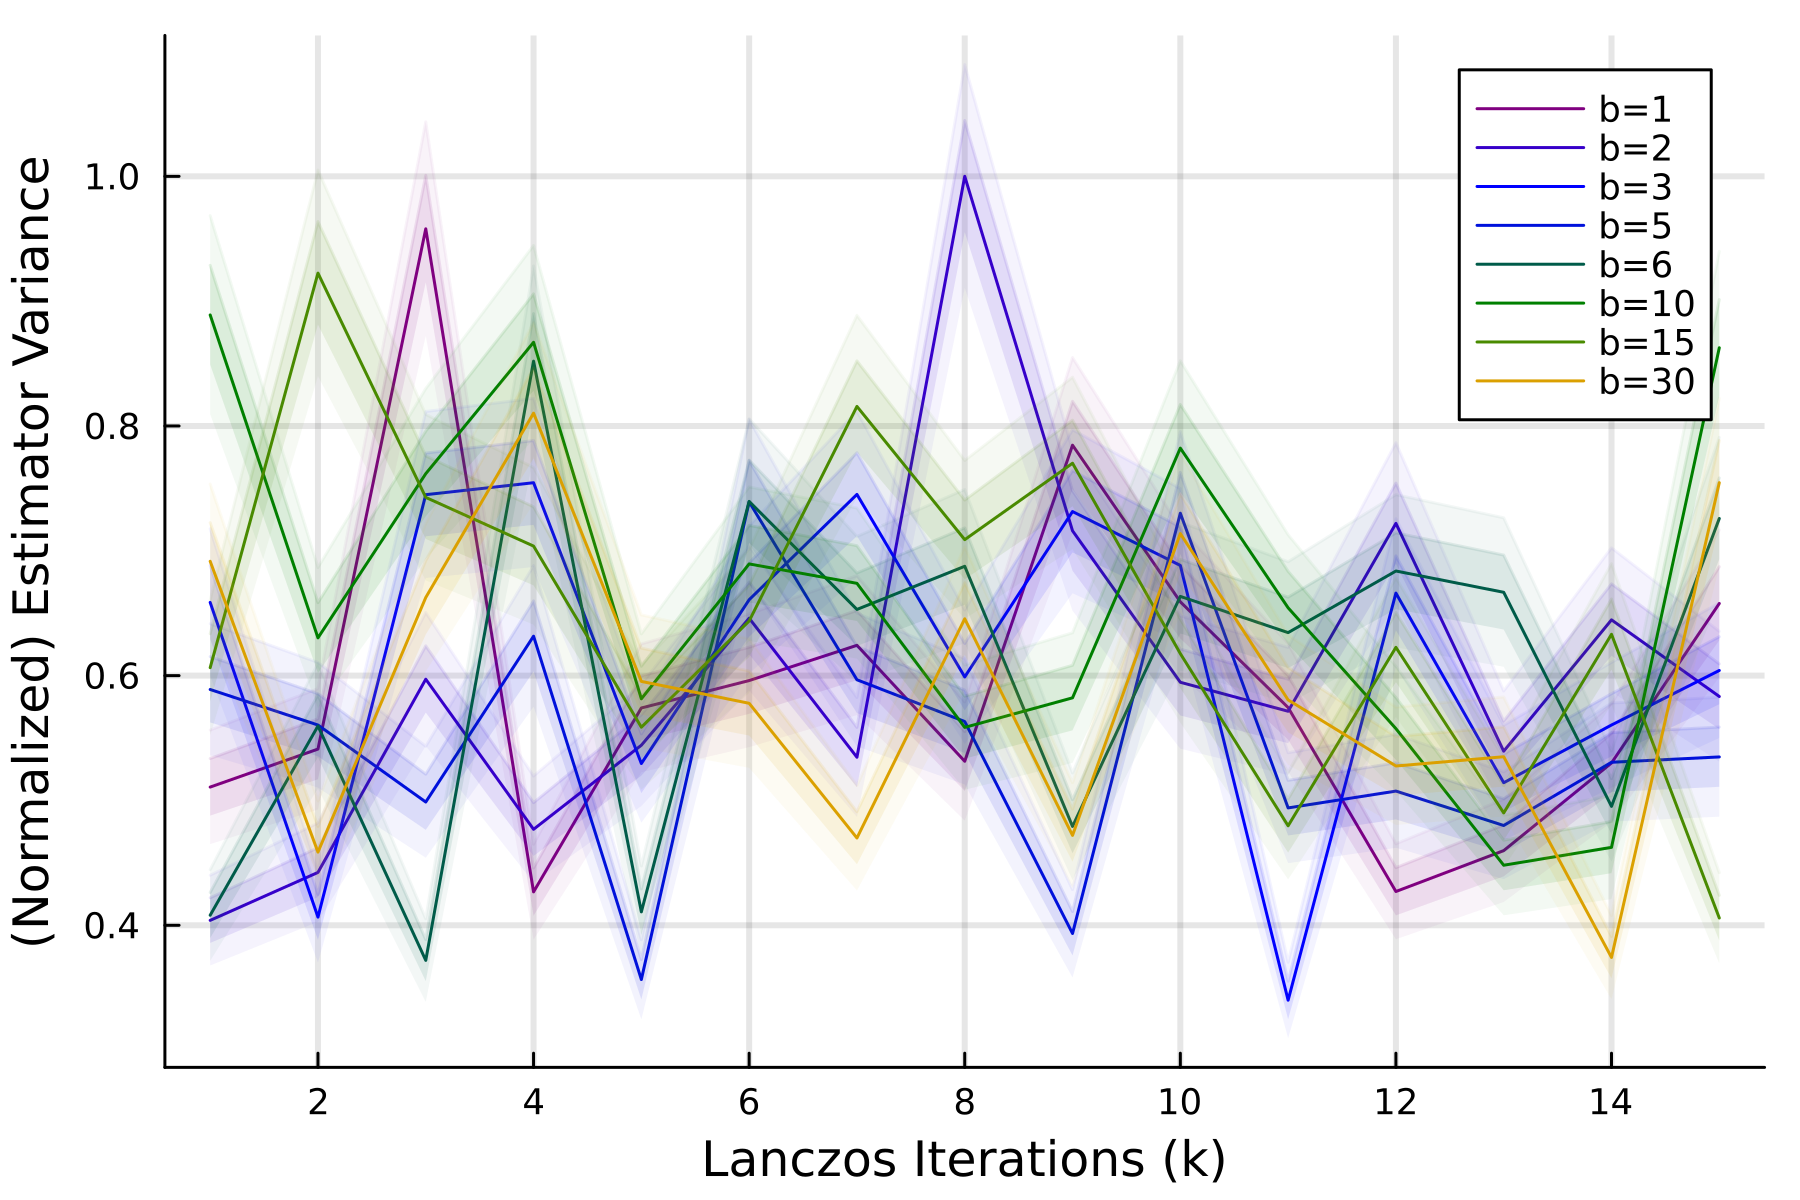

In [7]:
normalization = findmax(block_variance_estimates)[1]
p = plot_block_variance_estimates(block_variance_estimates./normalization, block_stddev_of_variance_estimates./normalization, ks, bs)
plot!(ylabel="(Normalized) Estimator Variance")
plot!(dpi=300)
display(p)

In [8]:
savefig("hutch_pp_estimator_variance_vs_lanczos_iters.png")

"/home/mlouis9/shared/Educational Stuffs/Classes/Fall 2024/Iterative Methods/project/test/hutch_pp_estimator_variance_vs_lanczos_iters.png"

## Hutch++ Estimator Variance w.r.t. Number of Samples and Block Size 
Now see what the estimator variance looks like as a function of the number of samples and the block size $b$. Unless things have gone catastrophically wrong, the estimator variance should decrease roughly quadratically with the sample size, and we hope it will do so independent of the block size, which is again supported by the previous experiments

In [2]:
# A slightly larger test case
include("bcsstk26_case.jl")

3.301334524101462e12

In [3]:
s_vals = collect(16:16:200)
bs = divisors(8)
k = 20
N = 20 # The number of samples for computing variance estimates
partial_hutch_pp_estimator = (b, s) -> 
                hutch_pp_estimator(f, matvecA, n, s, b, k; reorthogonalization_fraction=1.0)
partial_variance_estimator = (b, s) ->
                estimator_statistics(partial_hutch_pp_estimator, b, s; )[2] # Note [2] returns the variance, not the mean
block_variance_estimates = compute_block_estimates(s_vals, bs, partial_variance_estimator);
block_stddev_of_variance_estimates = block_variance_estimates .* sqrt(2/(N-1))

4×12 Matrix{Float64}:
 3.98209e21  1.57864e21  8.85117e20  …  1.23246e19  1.11515e19  1.5086e19
 4.46451e21  1.44036e21  6.61224e20     1.75739e19  1.22723e19  1.03531e19
 4.54103e21  1.60145e21  5.82061e20     2.41764e19  1.30052e19  1.12264e19
 4.69467e21  9.85466e20  8.66781e20     2.40309e19  1.03122e19  1.25322e19

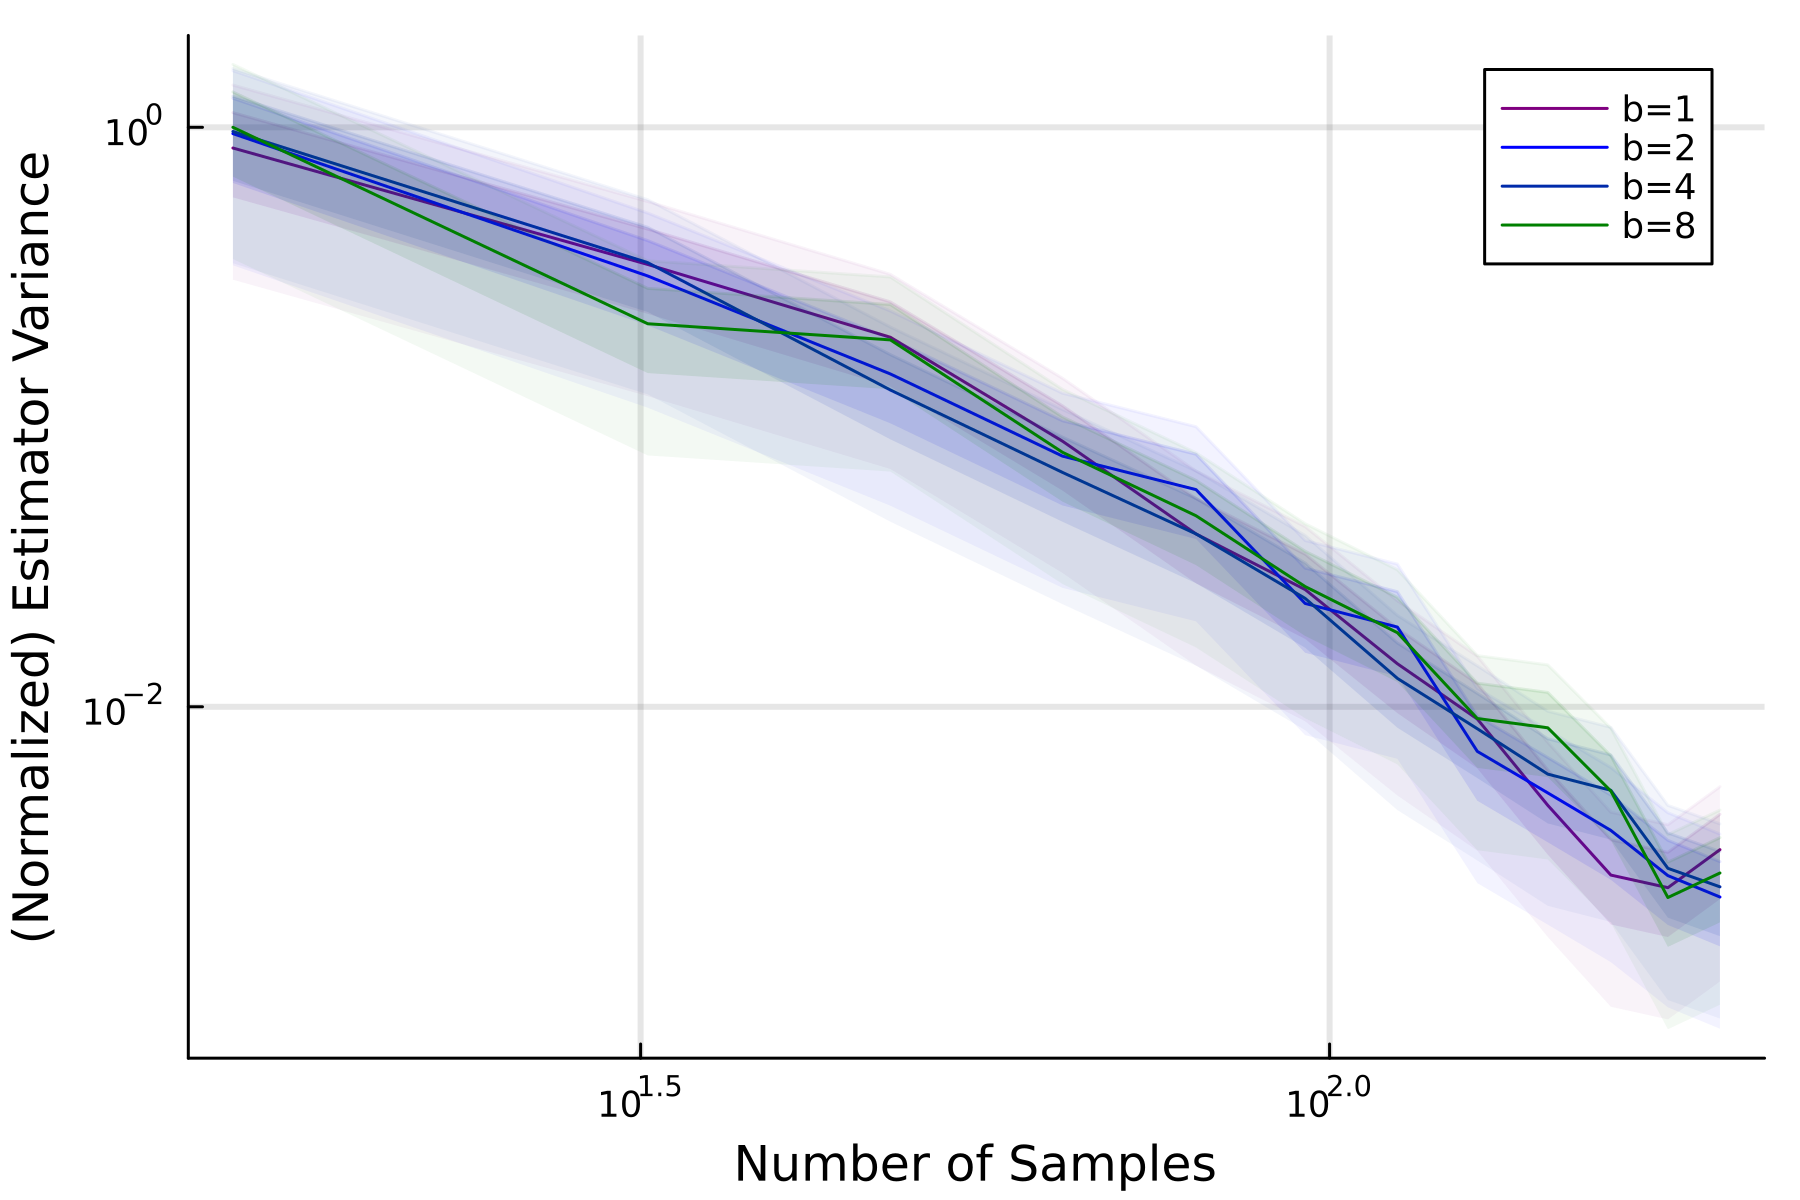

In [9]:
normalization = findmax(block_variance_estimates)[1]
p = plot_block_variance_estimates(block_variance_estimates./normalization, block_stddev_of_variance_estimates./normalization, s_vals, bs)
plot!(ylabel="(Normalized) Estimator Variance")
plot!(xlabel="Number of Samples")
plot!(yscale=:log10, xscale=:log10)
plot!(dpi=300)
display(p)

In [10]:
savefig("hutch_pp_estimator_variance_vs_samples.png")

"/home/mlouis9/shared/Educational Stuffs/Classes/Fall 2024/Iterative Methods/project/test/hutch_pp_estimator_variance_vs_samples.png"

## Hutch++ Estimator Variance w.r.t. Number of Samples and Block Size 
The same analysis as above, but with the Hutchinson estimator

In [3]:
s_vals = collect(16:16:200)
bs = divisors(16)
k = 20
N = 20 # The number of samples for computing variance estimates
partial_hutch_estimator = (b, s) -> 
                hutchinson_estimator(f, matvecA, n, s, b, k; reorthogonalization_fraction=1.0)
partial_variance_estimator = (b, s) ->
                estimator_statistics(partial_hutch_estimator, b, s; )[2] # Note [2] returns the variance, not the mean
block_variance_estimates = compute_block_estimates(s_vals, bs, partial_variance_estimator);
block_stddev_of_variance_estimates = block_variance_estimates .* sqrt(2/(N-1))

5×12 Matrix{Float64}:
 2.63092e21  1.58687e21  8.42615e20  …  2.75823e20  2.74004e20  2.81354e20
 1.38596e21  1.11286e21  8.18473e20     2.35883e20  2.52574e20  2.16089e20
 1.5549e21   1.09005e21  8.38743e20     1.95901e20  2.84427e20  1.88607e20
 2.00217e21  8.99465e20  6.01398e20     2.14792e20  1.61396e20  1.53363e20
 2.81803e21  1.18945e21  4.43778e20     2.27053e20  1.66569e20  1.8794e20

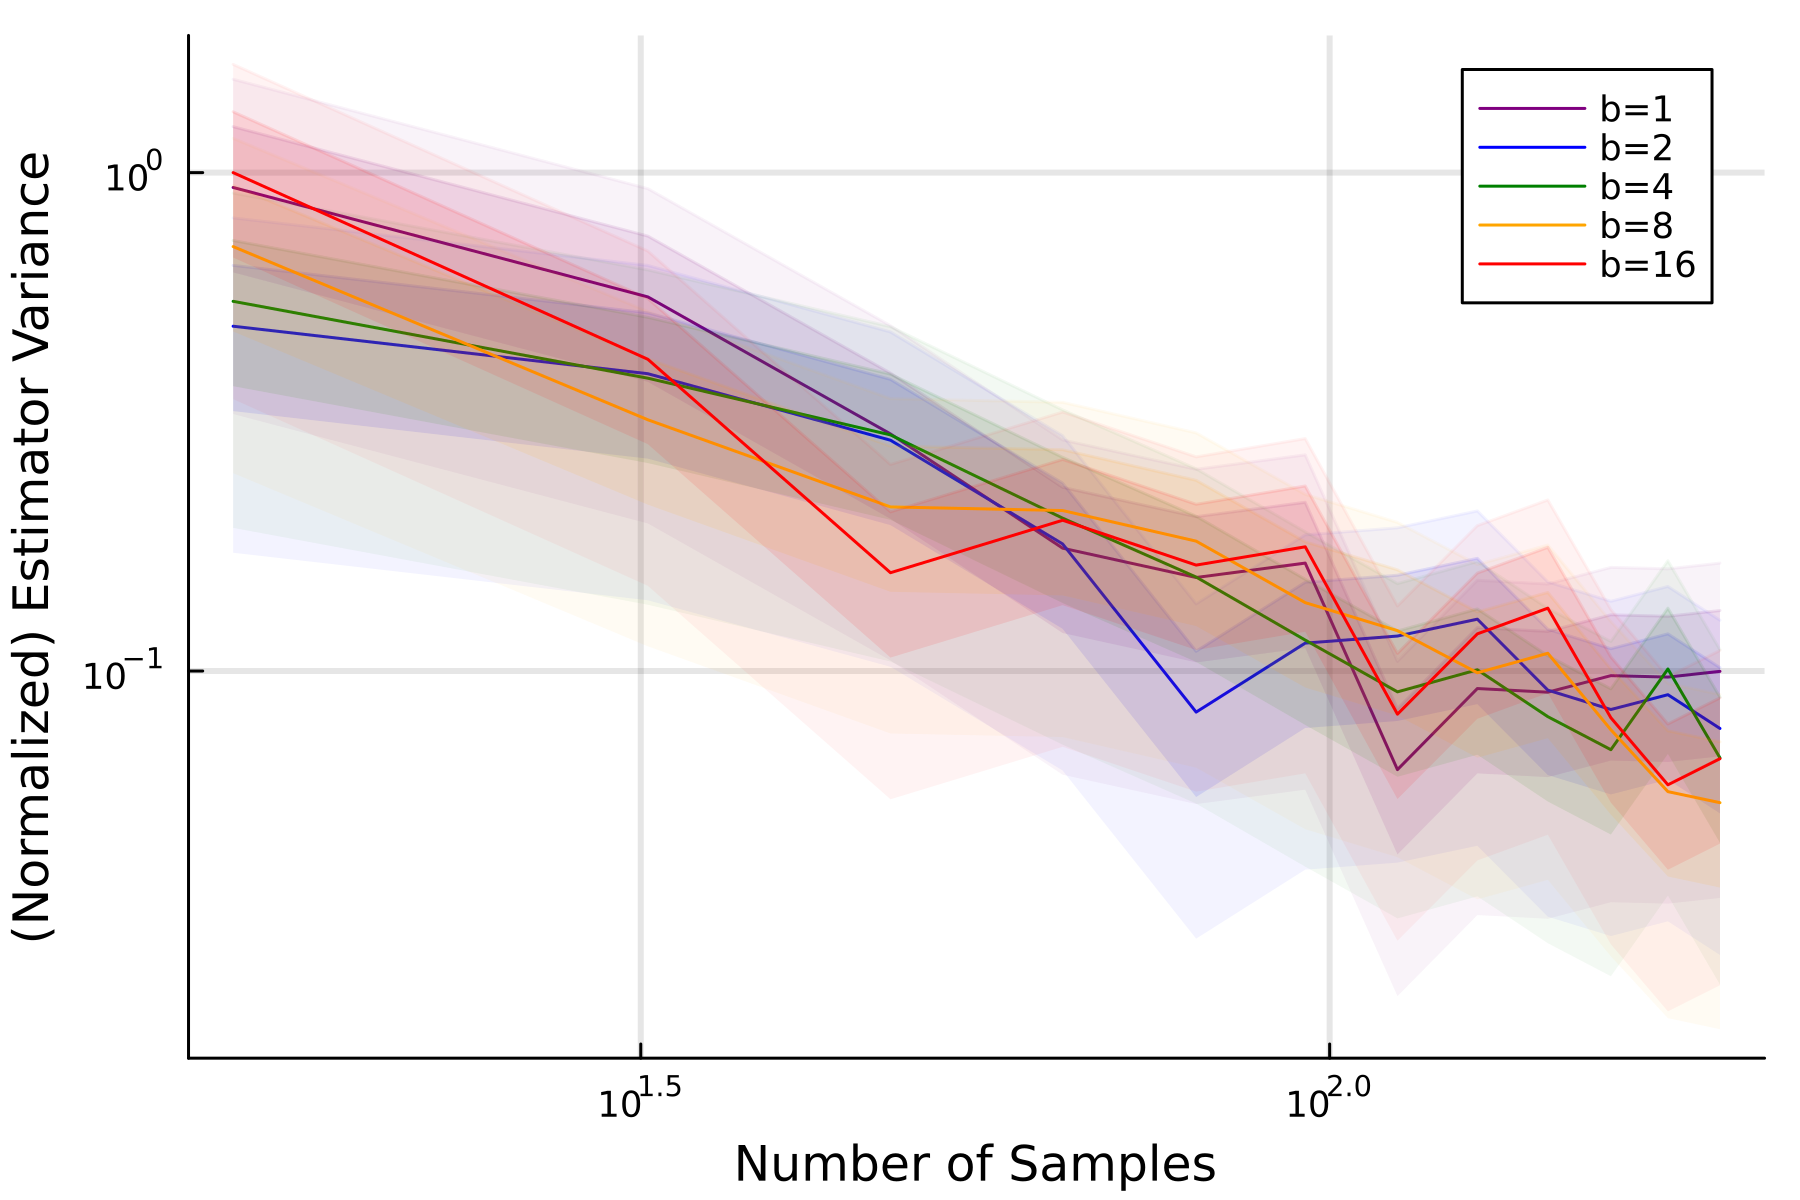

In [4]:
normalization = findmax(block_variance_estimates)[1]
p = plot_block_variance_estimates(block_variance_estimates./normalization, block_stddev_of_variance_estimates./normalization, s_vals, bs)
plot!(ylabel="(Normalized) Estimator Variance")
plot!(xlabel="Number of Samples")
plot!(yscale=:log10, xscale=:log10)
plot!(dpi=300)
display(p)

In [5]:
savefig("hutch_estimator_variance_vs_samples.png")

"/home/mlouis9/shared/Educational Stuffs/Classes/Fall 2024/Iterative Methods/project/test/hutch_estimator_variance_vs_samples.png"